In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import Files

In [2]:
dataset = pd.read_csv("creditcard_2023.csv")
dataset.head()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
1,1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,...,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37,0
2,2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,...,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54,0
3,3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,...,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44,0
4,4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97,0


In [3]:
df = dataset.drop("id", axis=1)
target_names = ["Class"]
feature_names = [name for name in df.columns if name not in target_names]

In [4]:
df[df.duplicated(subset=feature_names, keep=False)]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
323127,-1.704517,2.599199,-1.205391,0.503527,-0.949674,3.226002,-2.323095,-6.027712,0.273389,-0.698893,...,8.08708,-6.450353,6.343132,-1.075048,0.349881,-0.240261,1.534445,2.154102,22549.29,1
510531,-1.704517,2.599199,-1.205391,0.503527,-0.949674,3.226002,-2.323095,-6.027712,0.273389,-0.698893,...,8.08708,-6.450353,6.343132,-1.075048,0.349881,-0.240261,1.534445,2.154102,22549.29,1


In [5]:
df.drop_duplicates(subset=feature_names, inplace=True)

In [6]:
# Split data
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((454903, 29), (113726, 29), (454903,), (113726,))

# Standardization

In [7]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

In [8]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Metrics & Graph

In [9]:
from sklearn.metrics import (
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    accuracy_score, 
    precision_score, 
    recall_score,
    f1_score,
    make_scorer,
    log_loss)
from sklearn.model_selection import cross_val_predict
from tensorflow.keras.models import Sequential

def metrics(model,
            X_train,
            y_true_train,
            y_true_validate,
            y_pred_validate):
    # Forward the data
    if isinstance(model, Sequential):
        y_pred_train = model.predict(X_train)
        y_pred_train = (y_pred_train > 0.5).astype(int)
    else:
        y_pred_train = cross_val_predict(
                            estimator=model,
                            X=X_train,
                            y=y_true_train,
                            cv=3)
        
    # Calculate Accuracy score
    accuracy_train = accuracy_score(y_true_train,
                                    y_pred_train)
    accuracy_validate = accuracy_score(y_true_validate,
                                       y_pred_validate)
    
    # Calculate Precision score
    precision_train = precision_score(y_true_train,
                                      y_pred_train)
    precision_validate = precision_score(y_true_validate,
                                         y_pred_validate)
    
    # Calculata Recall score
    recall_train = recall_score(y_true_train,
                                y_pred_train)
    recall_validate = recall_score(y_true_validate,
                                   y_pred_validate)
    
    # Calculate F1-score to measure balance precision and recall score
    f1_train = f1_score(y_true_train,
                        y_pred_train)
    f1_validate = f1_score(y_true_validate,
                           y_pred_validate)
    
    # Make DataFrame
    data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1'],
    'Train': [accuracy_train, precision_train, recall_train, f1_train],
    'Validate': [accuracy_validate, precision_validate, recall_validate, f1_validate]
    }

    metrics_df = pd.DataFrame(data)

    # Set 'Metric' sebagai indeks DataFrame
    metrics_df.set_index('Metric', inplace=True)
    
    return metrics_df

def cm(y_true,
       y_pred,
       normalize):
    # Make Confusion Matrix
    cm = confusion_matrix(y_true, 
                          y_pred,
                          normalize=normalize)
    
    # Display the Confusion Matrix
    display = ConfusionMatrixDisplay(confusion_matrix=cm,
                                     display_labels = ["Non-Fraud", "Fraud"])
                                
    # Plot the Confusion Matrix
    display.plot(values_format=".2%",
                 colorbar=False)
    
    # Display the Plot
    plt.show()
    return cm

2023-10-26 16:12:54.580759: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
from sklearn.model_selection import learning_curve

# Make variable score
score = {"Accuracy": make_scorer(accuracy_score),
         "Precision": make_scorer(precision_score),
         "Recall Score": make_scorer(recall_score),
         "F1 Score": make_scorer(f1_score),
         "Loss": make_scorer(log_loss)}

def plot_learning_curve(model, 
                       x, y,
                       scoring='neg_mean_squared_error'):
    train_sizes, train_scores, val_scores = learning_curve(model, x, y, cv=5,
                                                           scoring=scoring)
    if scoring=='neg_mean_squared_error':
        train_scores_mean = -np.mean(train_scores, axis=1)
        val_scores_mean = -np.mean(val_scores, axis=1)
    else:
        train_scores_mean = np.mean(train_scores, axis=1)
        val_scores_mean = np.mean(val_scores, axis=1)
                       
    plt.figure(figsize=(6, 4))
    plt.plot(train_sizes, train_scores_mean, label='Training error')
    plt.plot(train_sizes, val_scores_mean, label='Validation error')
    plt.xlabel('Training set size')
    label = [key for key, value in score.items() if value == scoring]
    
    if label:
        plt.ylabel(label[0])  # Ambil label metrik dari dictionary score
        plt.title('Learning Curve for ' + label[0])
    else: 
        plt.ylabel("Mean Squared Error")
        plt.title("Learning Curve for Mean Squared Error")
    plt.legend()
    plt.show()

# Logistic Regression

In [96]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression(random_state=1)
logistic.fit(X_train, y_train)

LogisticRegression(random_state=1)

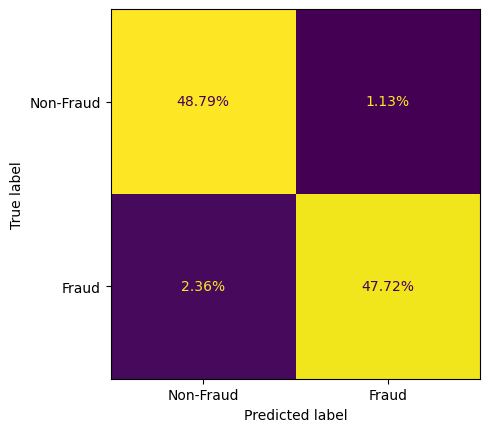

,Train,Validate
Metric,,
Accuracy,0.964808,0.965136
Precision,0.977869,0.976924
Recall,0.951112,0.952893
F1,0.964305,0.964759


In [172]:
y_pred = logistic.predict(X_test)
cm_log = cm(y_true=y_test,
            y_pred=y_pred,
            normalize='all')
log_metrics = metrics(logistic,
                     X_train, 
                     y_train,
                     y_test,
                     y_pred)
log_metrics

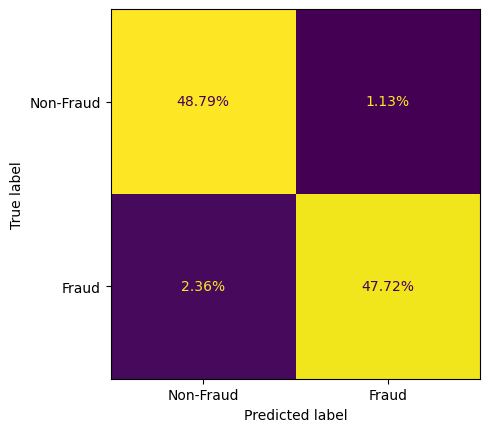

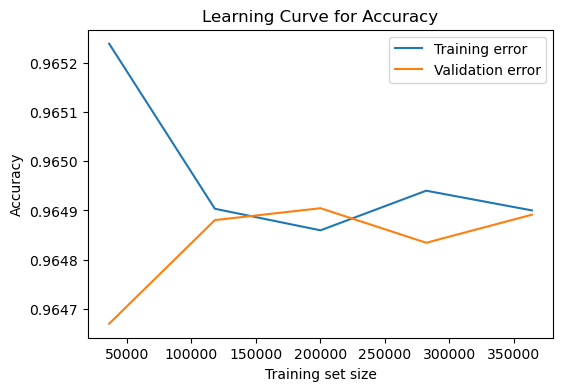

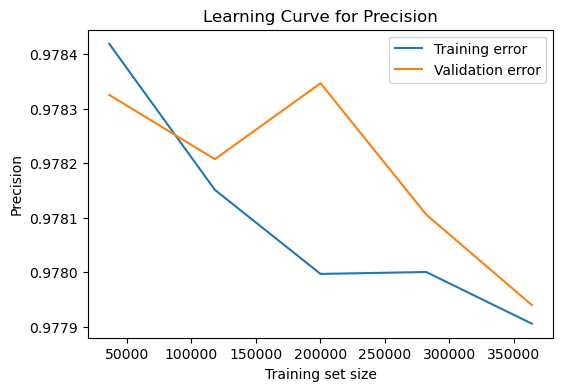

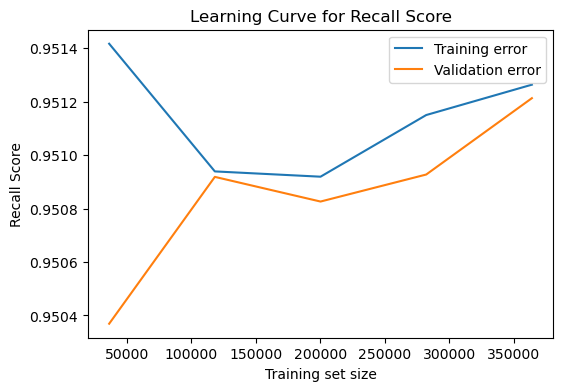

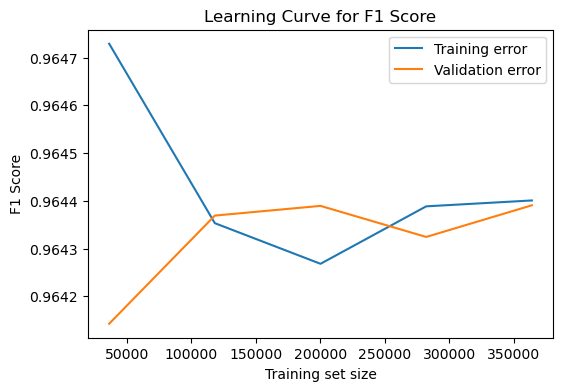

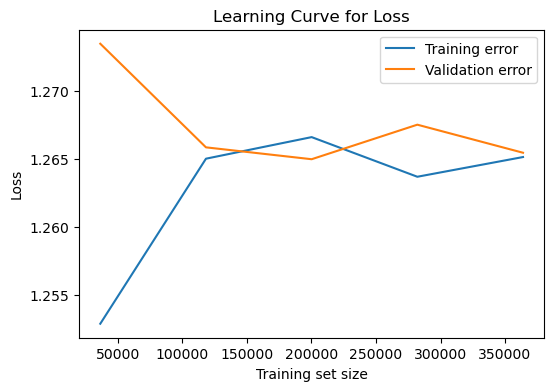

,Train,Validate
Metric,,
Accuracy,0.964808,0.965136
Precision,0.977869,0.976924
Recall,0.951112,0.952893
F1,0.964305,0.964759


In [97]:
for scoring in score:
    log_learning_curve = plot_learning_curve(logistic, 
                                             X_train, 
                                             y_train,
                                             scoring=score[scoring])

# SGDClassifier


In [13]:
from sklearn.linear_model import SGDClassifier
SGD = SGDClassifier(random_state=1)
SGD.fit(X_train, y_train)

SGDClassifier(random_state=1)

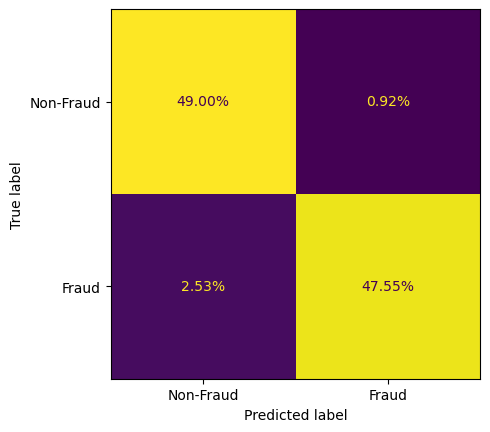

,Train,Validate
Metric,,
Accuracy,0.965351,0.965478
Precision,0.982083,0.981041
Recall,0.947968,0.949417
F1,0.964724,0.964970


In [173]:
SGD_pred = SGD.predict(X_test)
cm_SGD = cm(y_true=y_test,
            y_pred=SGD_pred,
            normalize='all')
SGD_metrics = metrics(SGD,
                     X_train,
                     y_train,
                     y_test, 
                     SGD_pred)
SGD_metrics

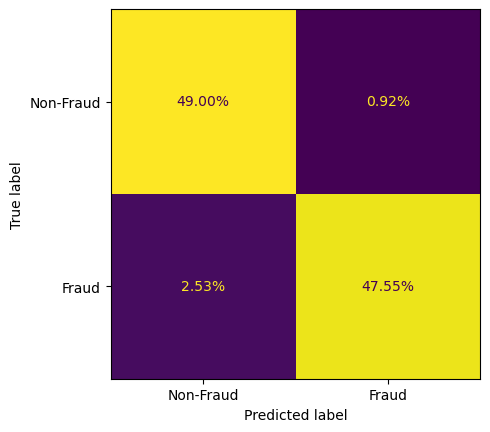

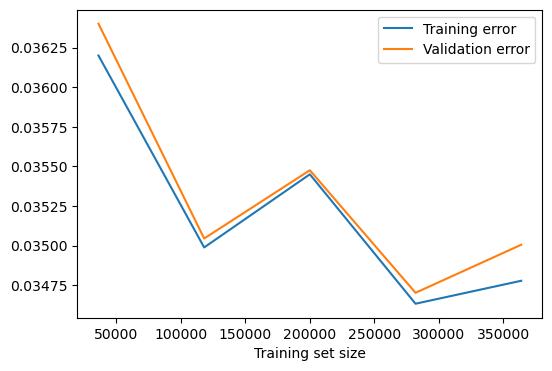

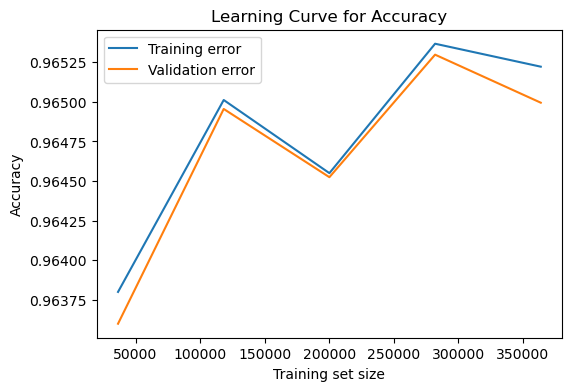

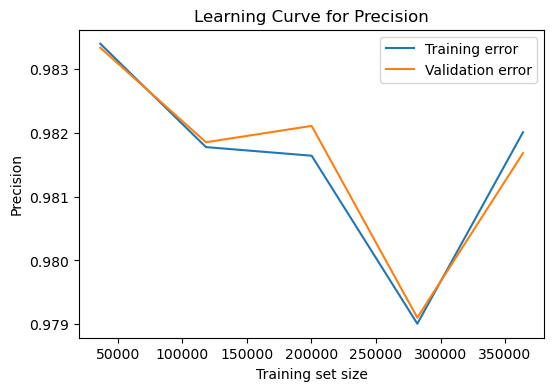

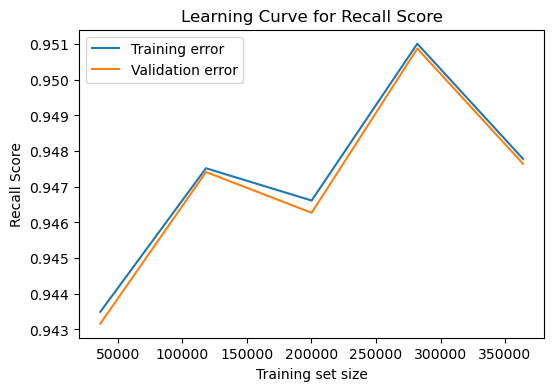

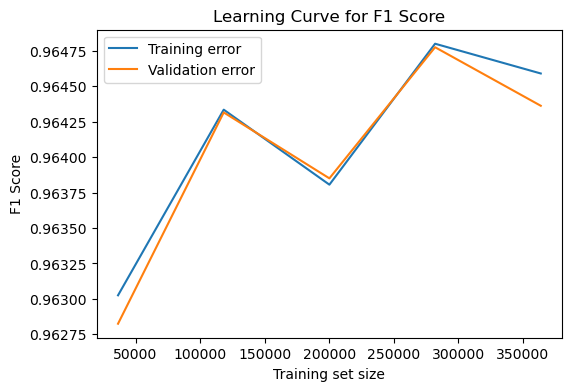

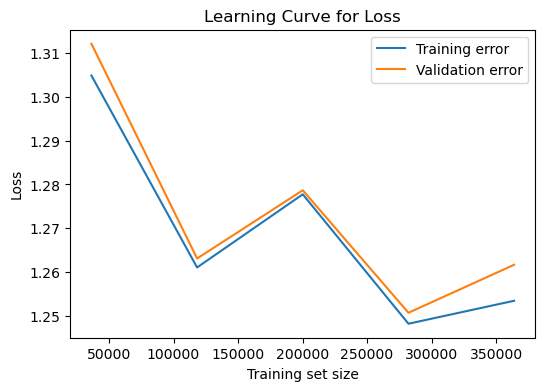

,Train,Validate
Metric,,
Accuracy,0.965351,0.965478
Precision,0.982083,0.981041
Recall,0.947968,0.949417
F1,0.964724,0.964970


In [14]:
for scoring in score:
    SGD_learning_curve = plot_learning_curve(SGD, 
                                             X_train, 
                                             y_train,
                                             scoring=score[scoring])

# GaussianNB

In [15]:
from sklearn.naive_bayes import GaussianNB
GNB = GaussianNB()
GNB.fit(X_train, y_train)

GaussianNB()

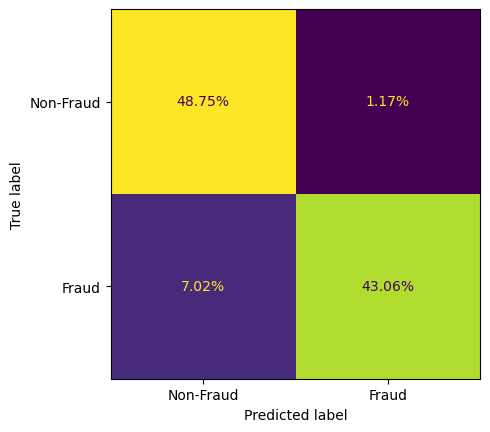

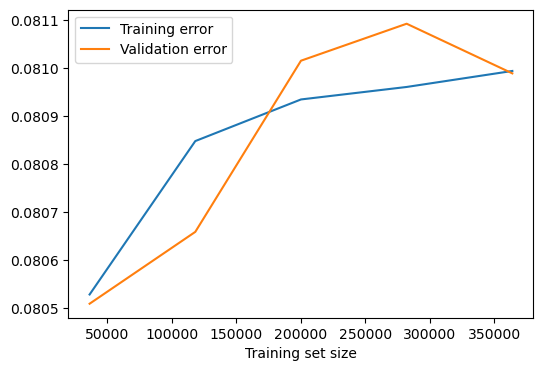

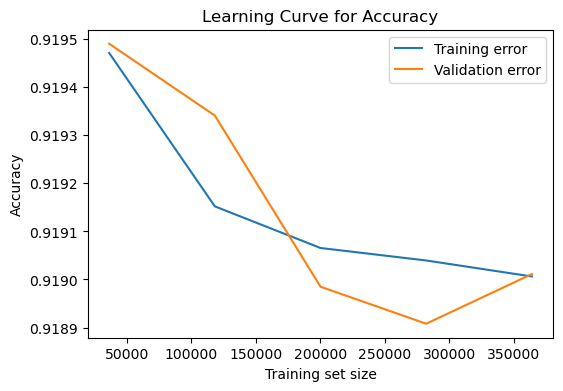

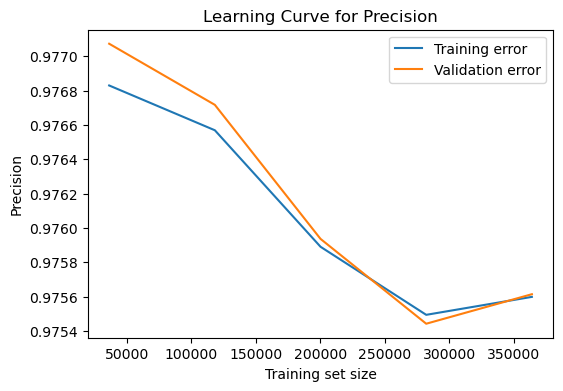

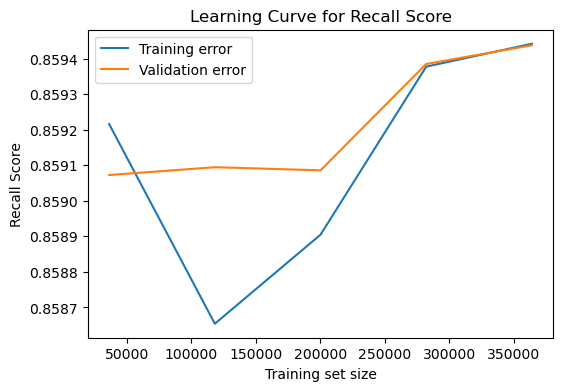

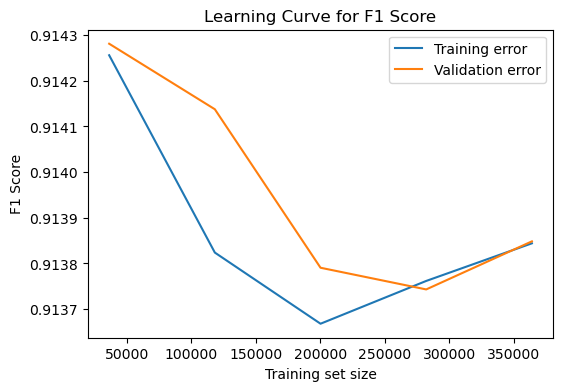

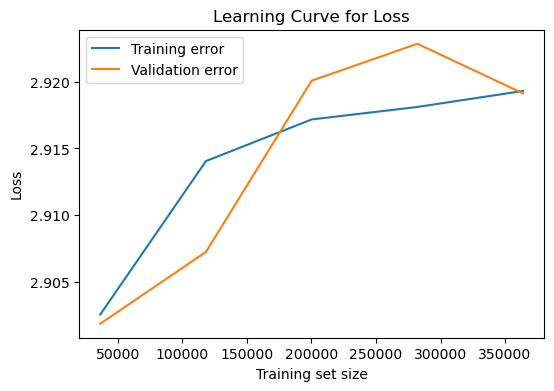

,Train,Validate
Metric,,
Accuracy,0.918886,0.918145
Precision,0.975589,0.973619
Recall,0.859204,0.859857
F1,0.913705,0.913208


In [16]:
GNB_pred = GNB.predict(X_test)
cm_GNB = cm(y_test,
            GNB_pred,
            normalize='all')
GNB_metrics = metrics(GNB,
                      X_train,
                      y_train,
                      y_test,
                      GNB_pred)
for scoring in score:
    GNB_learning_curve = plot_learning_curve(GNB, 
                                             X_train, 
                                             y_train,
                                             scoring=score[scoring])
GNB_metrics

# CatBoost

In [140]:
from catboost import CatBoostClassifier
CGB = CatBoostClassifier(iterations=300,
                         depth=7,
                         learning_rate=0.03,
                         loss_function='Logloss',
                         verbose=False)
CGB.fit(X_train, y_train)

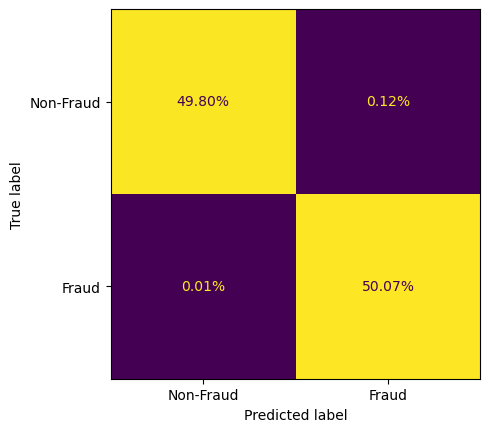

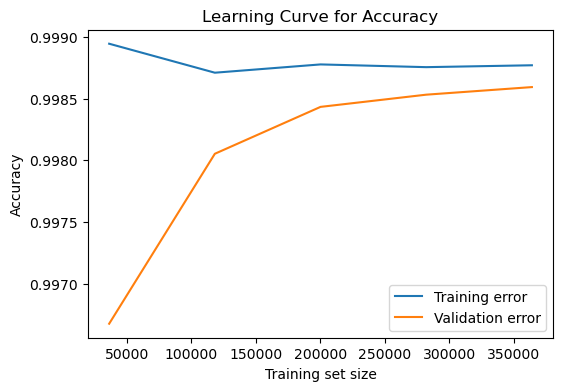

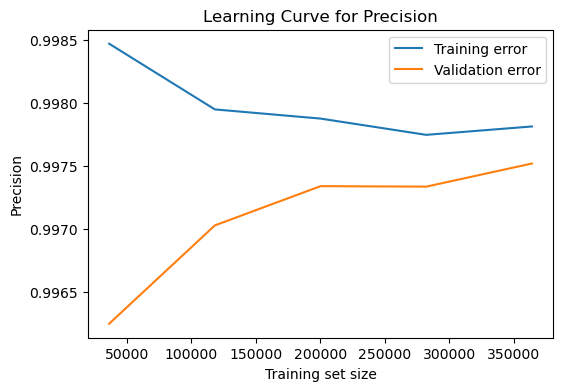

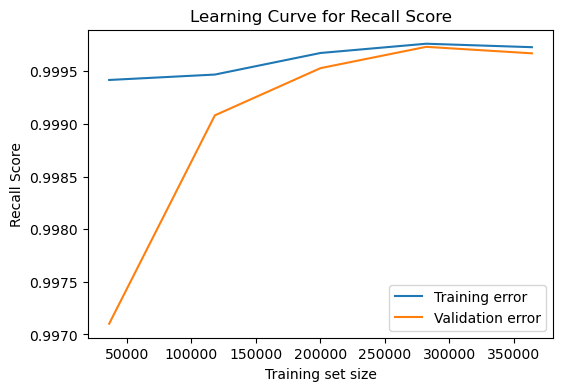

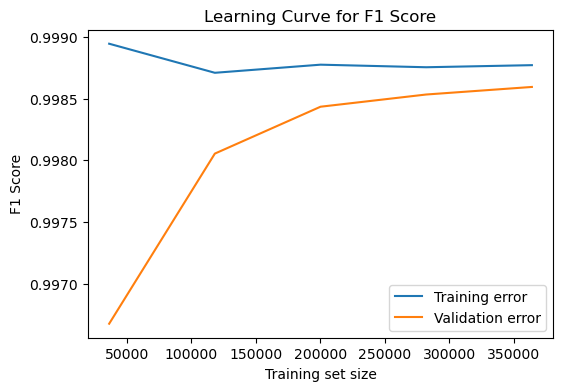

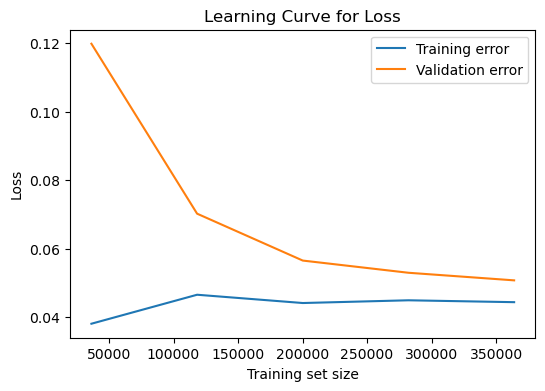

,Train,Validate
Metric,,
Accuracy,0.998461,0.998655
Precision,0.997288,0.997617
Recall,0.999639,0.999702
F1,0.998462,0.998658


In [145]:
CGB_pred = CGB.predict(X_test)
cm_CGB = cm(y_test,
            CGB_pred,
            normalize='all')
CGB_metrics = metrics(CGB,
                      X_train,
                      y_train,
                      y_test,
                      CGB_pred)
for scoring in score:
    CGB_learning_curve = plot_learning_curve(CGB, 
                                             X_train, 
                                             y_train,
                                             scoring=score[scoring])
CGB_metrics

# Boost the Model using PCA

In [84]:
# Calcualte how much the components needed to retain 95% data
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# Normalization and fit the data
normal = MinMaxScaler()
X_normal = normal.fit_transform(X)

# Create and fit PCA with standardized data
pca_standardization = PCA()
X_pca_standardization = pca_standardization.fit_transform(X_train)

# Create and fit PCA with normalized data
pca_normalization = PCA()
X_pca_normalization = pca_normalization.fit_transform(X_normal)

# Calculate num components
num_var_standard = np.cumsum(pca_standardization.explained_variance_ratio_)
num_var_normal = np.cumsum(pca_normalization.explained_variance_ratio_)

num_components_standard = np.argmax(num_var_standard >= 0.95) + 1
num_components_normal = np.argmax(num_var_normal >= 0.95) + 1
print(f"Number of components needed to retain 95% of the standard data: {num_components_standard}")
print(f"Number of components needed to retain 95% of the normalized data: {num_components_normal}")

Number of components needed to retain 95% of the standard data: 22
Number of components needed to retain 95% of the normalized data: 11


In [86]:
# Reduce amount of components
# Standardization
pca_std = PCA(n_components=num_components_standard)
X_reduced_std = pca_std.fit_transform(X_train)
print(f"X shape after reduced: {X_reduced_std.shape}")

# Normalization
pca_normal = PCA(n_components=num_components_normal)
X_reduced_normal = pca_normal.fit_transform(X_normal)
print(f"X shape after reduced: {X_reduced_normal.shape}")

X shape after reduced: (454903, 22)
X shape after reduced: (568629, 11)


In [91]:
# Split the data
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_reduced_normal, y, 
                                                                    test_size=0.2, 
                                                                    random_state=1)
print("x_train_pca shape:" , X_train_pca.shape)
print("y_train_pca shape:" , y_train_pca.shape)
print("x_test_pca shape:" , X_test_pca.shape)
print("y_test_pca shape:" , y_test_pca.shape)

x_train_pca shape: (454903, 11)
y_train_pca shape: (454903,)
x_test_pca shape: (113726, 11)
y_test_pca shape: (113726,)


# Logistic Regression Boost by PCA

In [98]:
Log_pca = LogisticRegression(random_state=1)
Log_pca.fit(X_train_pca, y_train_pca)

LogisticRegression(random_state=1)

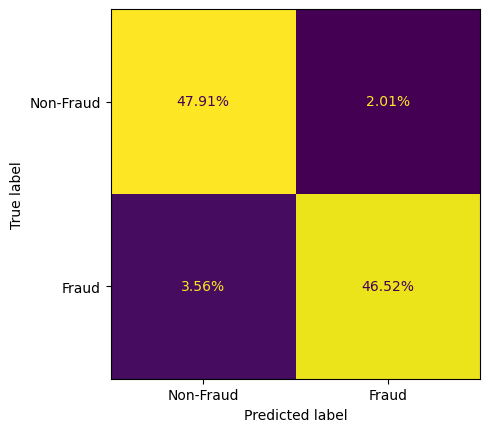

In [115]:
y_pred_pca = Log_pca.predict(X_test_pca)
cm_log_pca = cm(y_true=y_test_pca,
            y_pred=y_pred_pca,
            normalize='all')
log_metrics_pca = metrics(Log_pca,
                     X_train_pca, 
                     y_train_pca,
                     y_test_pca,
                     y_pred_pca)

In [116]:
log_metrics_pca

,Train,Validate
Metric,,
Accuracy,0.943388,0.944252
Precision,0.958395,0.958545
Recall,0.926970,0.928857
F1,0.942421,0.943468


In [106]:
metric_log

,Train,Validate
Metric,,
Accuracy,0.964808,0.965136
Precision,0.977869,0.976924
Recall,0.951112,0.952893
F1,0.964305,0.964759


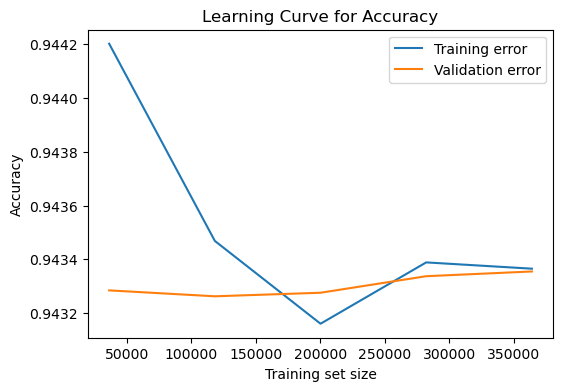

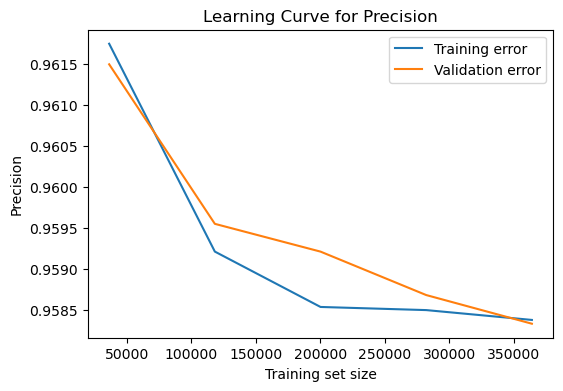

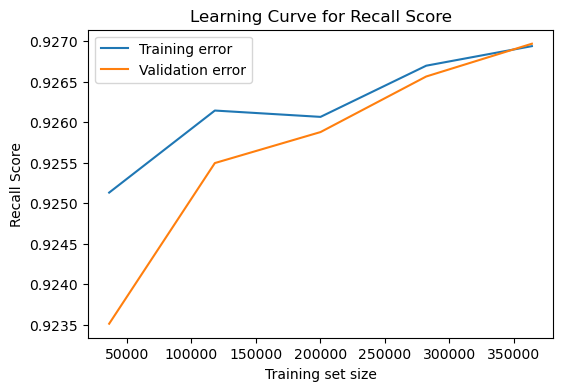

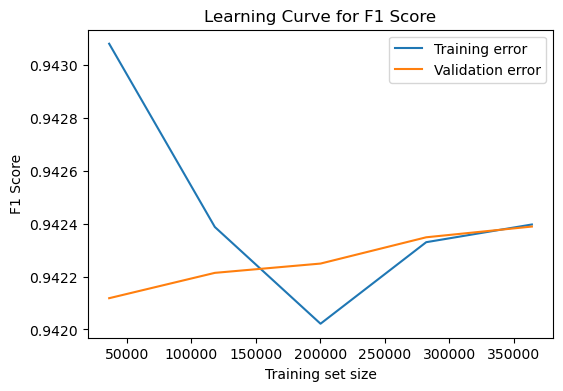

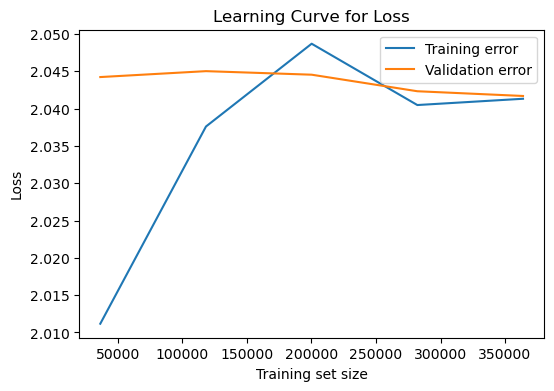

In [117]:
for scoring in score:
    log_pca_learning_curve = plot_learning_curve(Log_pca, 
                                                 X_train_pca, 
                                                 y_train_pca,
                                                 scoring=score[scoring])

# SGDClassifier Boost by PCA

In [121]:
SGD_pca = SGDClassifier(random_state=1)
SGD_pca.fit(X_train_pca, y_train_pca)

SGDClassifier(random_state=1)

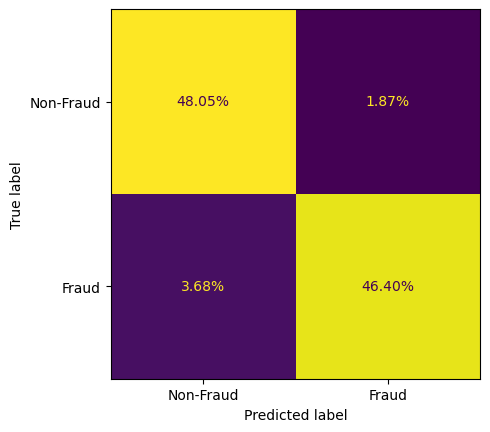

In [122]:
SGD_pred_pca = SGD_pca.predict(X_test_pca)
cm_SGD_pca = cm(y_true=y_test_pca,
                y_pred=SGD_pred_pca,
                normalize='all')
SGD_metrics_pca = metrics(SGD_pca,
                         X_train_pca,
                         y_train_pca,
                         y_test_pca, 
                         SGD_pred_pca)

In [123]:
SGD_metrics_pca

,Train,Validate
Metric,,
Accuracy,0.943012,0.944445
Precision,0.963920,0.961201
Recall,0.920429,0.926470
F1,0.941673,0.943516


In [124]:
metric_SGD

,Train,Validate
Metric,,
Accuracy,0.965351,0.965478
Precision,0.982083,0.981041
Recall,0.947968,0.949417
F1,0.964724,0.964970


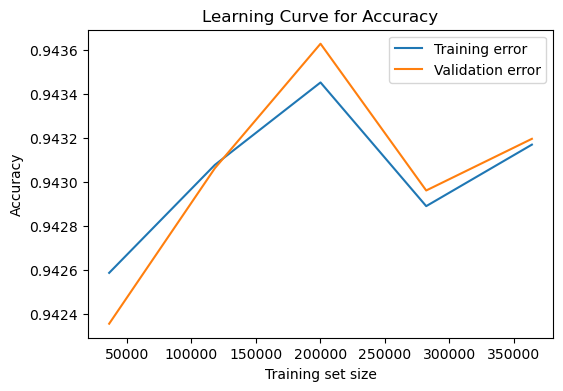

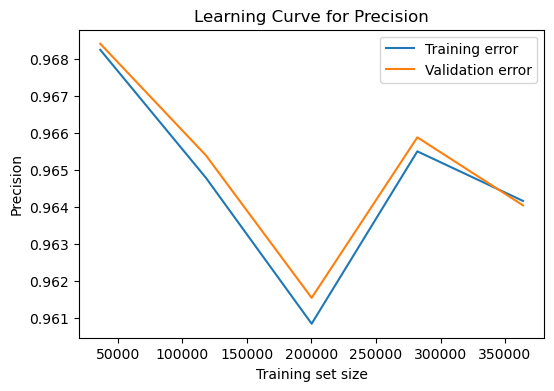

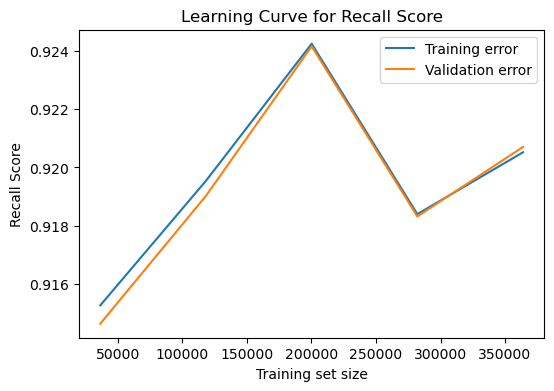

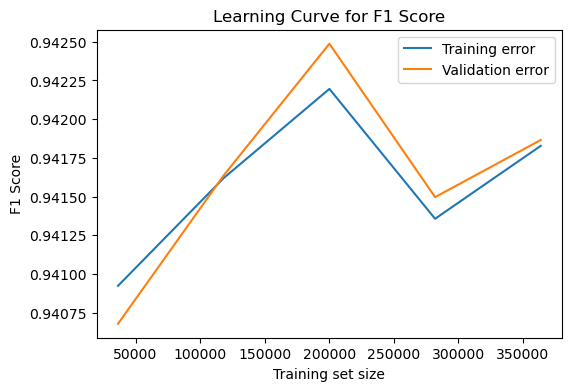

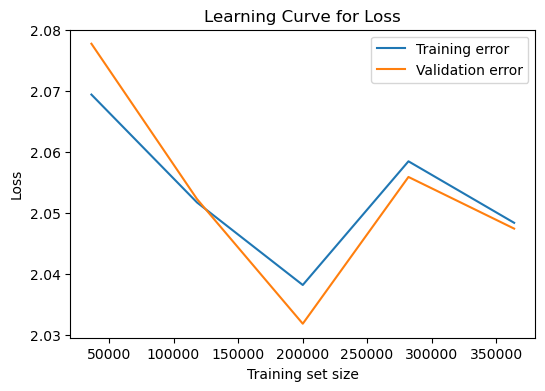

In [125]:
for scoring in score:
    SGD_pca_learning_curve = plot_learning_curve(SGD_pca, 
                                             X_train_pca, 
                                             y_train_pca,
                                             scoring=score[scoring])


# GaussianNB Boost by PCA

In [127]:
GNB_pca = GaussianNB()
GNB_pca.fit(X_train_pca, y_train_pca)

GaussianNB()

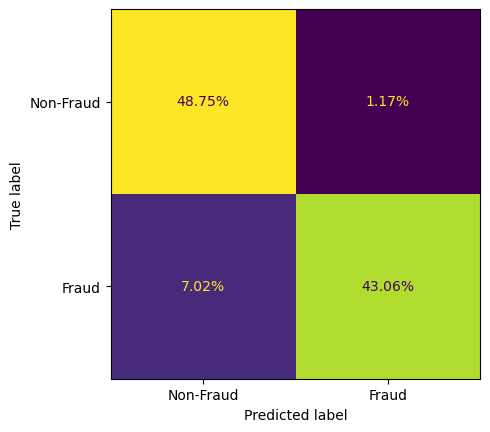

,Train,Validate
Metric,,
Accuracy,0.921667,0.918145
Precision,0.966196,0.973619
Recall,0.873842,0.859857
F1,0.917701,0.913208


In [129]:
GNB_pred_pca = GNB.predict(X_test)
cm_GNB_pca = cm(y_test_pca,
                GNB_pred_pca,
                normalize='all')
GNB_metrics_pca = metrics(GNB_pca,
                          X_train_pca,
                          y_train_pca,
                          y_test_pca,
                          GNB_pred_pca)

GNB_metrics_pca

In [130]:
GNB_metrics

,Train,Validate
Metric,,
Accuracy,0.918886,0.918145
Precision,0.975589,0.973619
Recall,0.859204,0.859857
F1,0.913705,0.913208


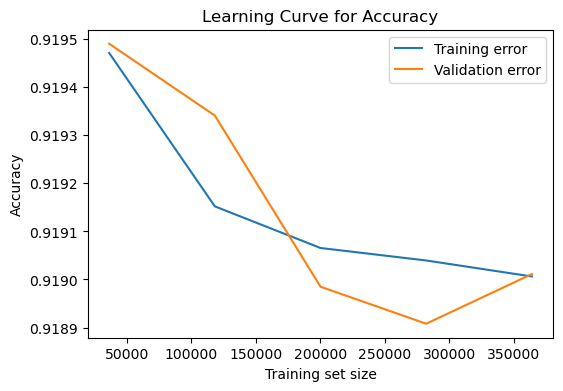

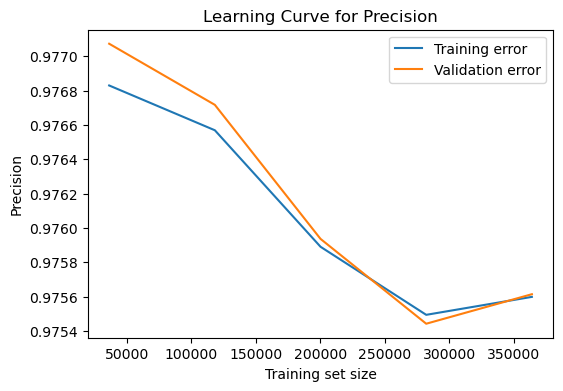

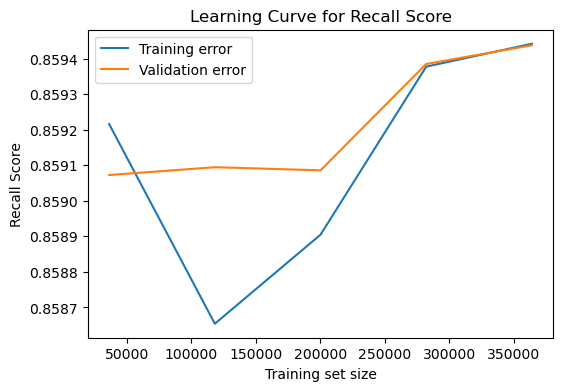

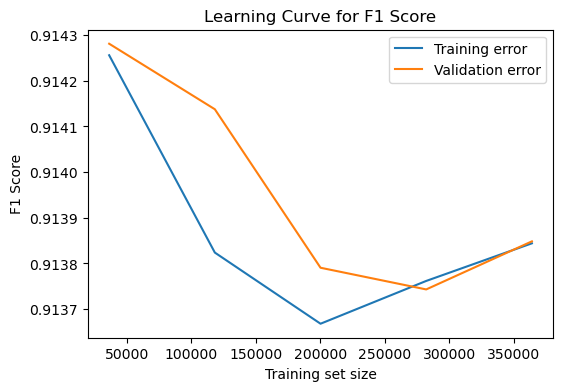

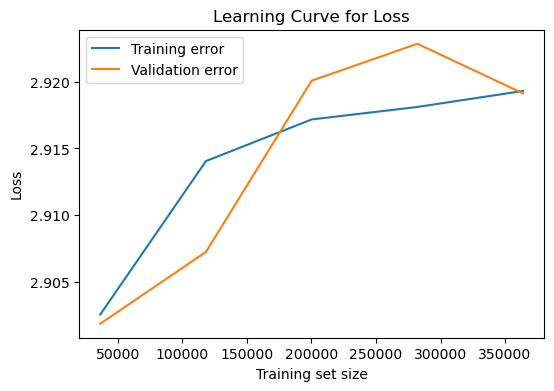

In [131]:
for scoring in score:
    GNB_pca_learning_curve = plot_learning_curve(GNB, 
                                             X_train, 
                                             y_train,
                                             scoring=score[scoring])

# CatBoost Model boost by PCA

In [165]:
CGB_pca = CatBoostClassifier(iterations=300,
                             depth=7,
                             learning_rate=0.03,
                             loss_function='Logloss',
                             verbose=False)
CGB_pca.fit(X_train_pca, y_train_pca)

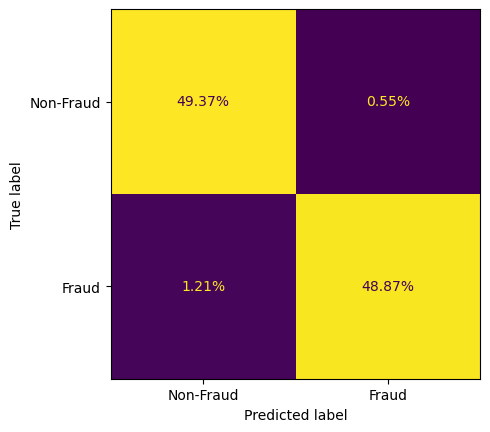

,Train,Validate
Metric,,
Accuracy,0.982016,0.982396
Precision,0.988752,0.988915
Recall,0.975110,0.975788
F1,0.981884,0.982308


In [166]:
CGB_pred_pca = CGB_pca.predict(X_test_pca)
cm_CGB_pca = cm(y_test_pca,
                CGB_pred_pca,
                normalize='all')
CGB_metrics_pca = metrics(CGB_pca,
                          X_train_pca,
                          y_train_pca,
                          y_test_pca,
                          CGB_pred_pca)

CGB_metrics_pca

In [167]:
CGB_metrics

,Train,Validate
Metric,,
Accuracy,0.998461,0.998655
Precision,0.997288,0.997617
Recall,0.999639,0.999702
F1,0.998462,0.998658


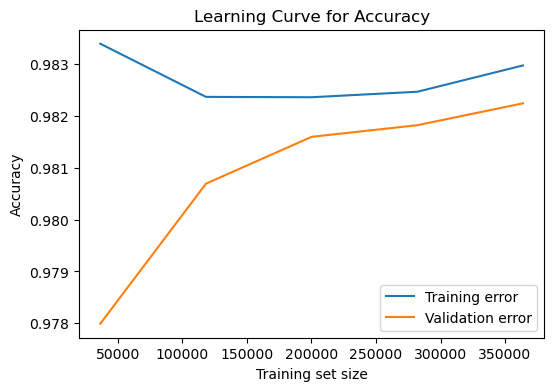

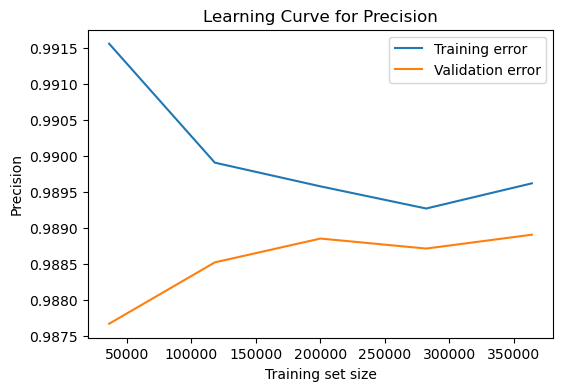

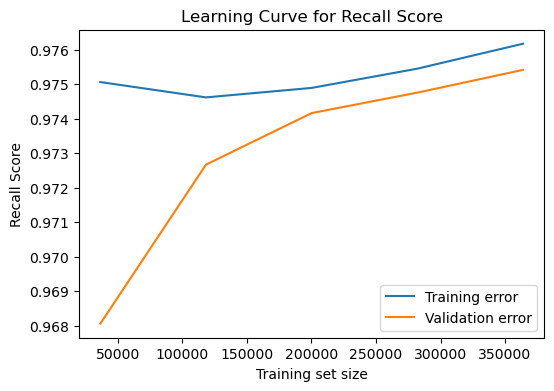

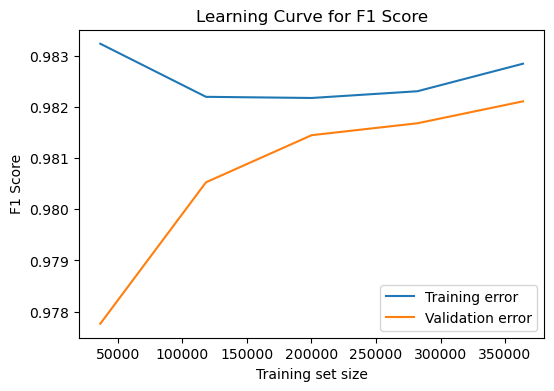

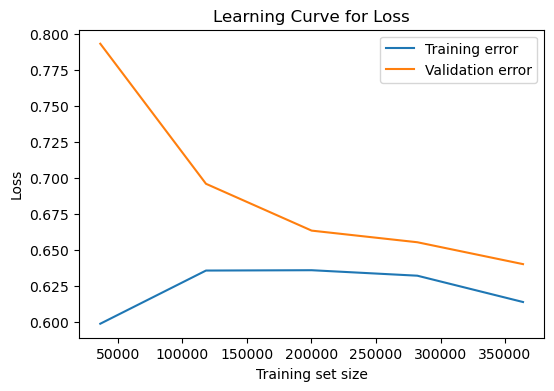

In [168]:
for scoring in score:
    CGB_pca_learning_curve = plot_learning_curve(CGB_pca, 
                                                 X_train_pca, 
                                                 y_train_pca,
                                                 scoring=score[scoring])

# Neural Network

In [23]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

def nn_model(hidden_layers, output_layers):
    # Declare the model
    model = Sequential()

    # Add layer
    model.add(Dense(hidden_layers, activation="relu"))
    model.add(Dense(hidden_layers, activation="relu"))
    model.add(Dense(output_layers, activation="sigmoid"))
    
    # Compile
    model.compile(optimizer="adam", metrics=["accuracy"], loss="binary_crossentropy")
    return model

ANN = KerasClassifier(build_fn=nn_model, 
                      hidden_layers=100, 
                      output_layers=1)

/var/folders/5l/gpxf0q0109zg94jq7ssf5dj40000gn/T/ipykernel_41109/1633819957.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  ANN = KerasClassifier(build_fn=nn_model,


In [24]:
ANN.fit(X_train, 
        y_train, 
        epochs=10, 
        batch_size=32)

Epoch 1/10
14216/14216 [==============================] - 14s 947us/step - loss: 0.0184 - accuracy: 0.9939
Epoch 2/10
14216/14216 [==============================] - 14s 976us/step - loss: 0.0052 - accuracy: 0.9986
Epoch 3/10
14216/14216 [==============================] - 14s 955us/step - loss: 0.0040 - accuracy: 0.9990
Epoch 4/10
14216/14216 [==============================] - 14s 978us/step - loss: 0.0030 - accuracy: 0.9992
Epoch 5/10
14216/14216 [==============================] - 14s 998us/step - loss: 0.0026 - accuracy: 0.9994
Epoch 6/10
14216/14216 [==============================] - 15s 1ms/step - loss: 0.0024 - accuracy: 0.9994
Epoch 7/10
14216/14216 [==============================] - 18s 1ms/step - loss: 0.0019 - accuracy: 0.9995
Epoch 8/10
14216/14216 [==============================] - 20s 1ms/step - loss: 0.0021 - accuracy: 0.9995
Epoch 9/10
14216/14216 [==============================] - 18s 1ms/step - loss: 0.0017 - accuracy: 0.9996
Epoch 10/10
14216/14216 [====================

11373/11373 [==============================] - 10s 873us/step


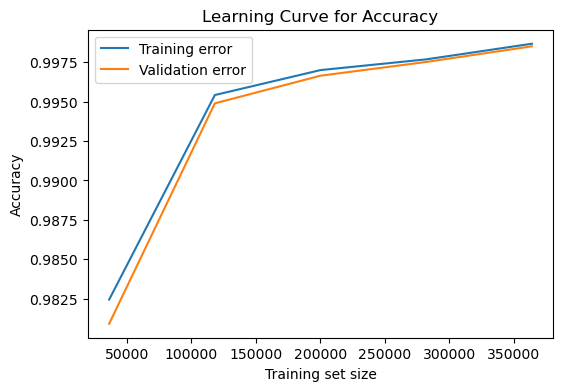

11373/11373 [==============================] - 13s 1ms/step


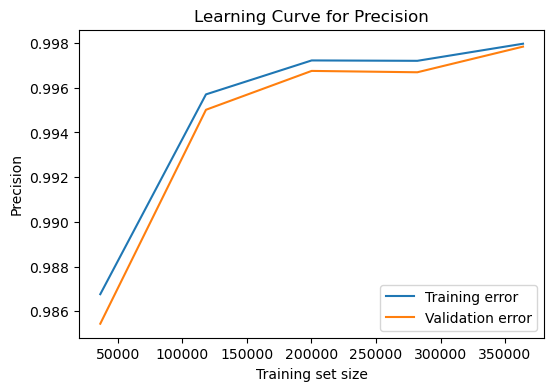

11373/11373 [==============================] - 10s 867us/step


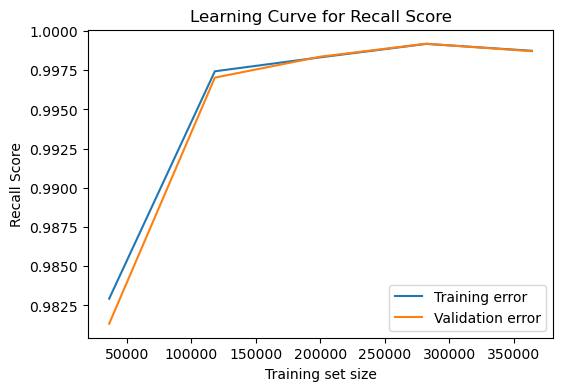

11373/11373 [==============================] - 10s 856us/step


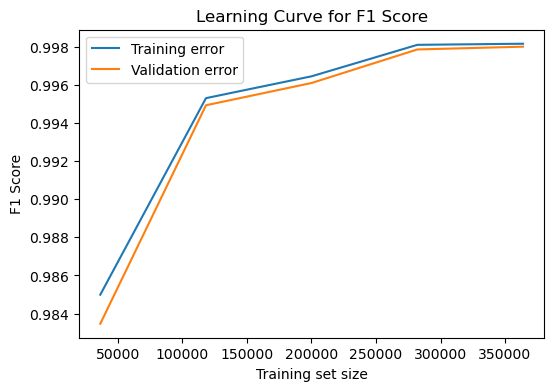

11373/11373 [==============================] - 12s 1ms/step


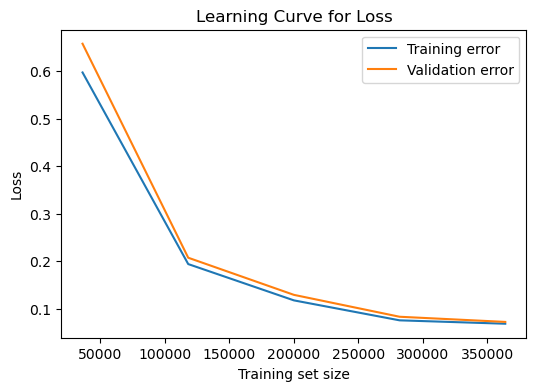

In [25]:
for scoring in score:
    ann_learning_curve = plot_learning_curve(ANN, 
                                             X_train, 
                                             y_train,
                                             scoring=score[scoring])

11373/11373 [==============================] - 9s 774us/step


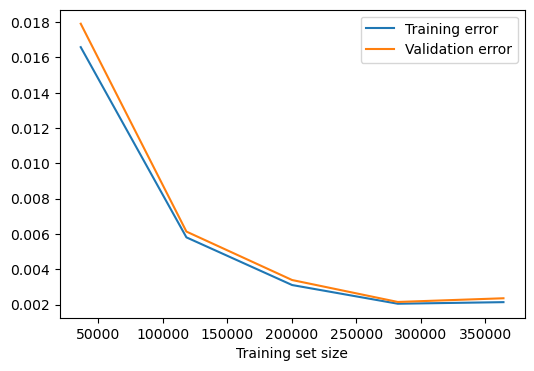

In [27]:
plot_learning_curve(ANN,
                    X_train, 
                    y_train)

3554/3554 [==============================] - 3s 773us/step


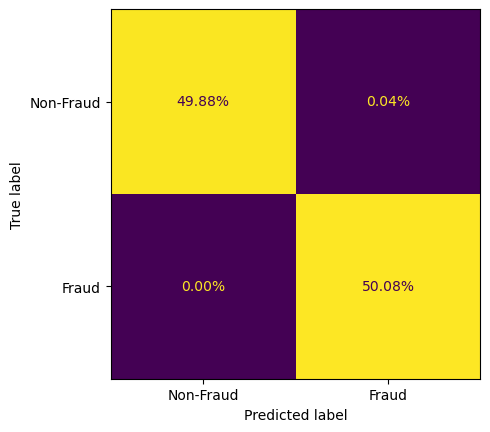

4739/4739 [==============================] - 3s 660us/step


,Train,Validate
Metric,,
Accuracy,0.997248,0.999569
Precision,0.996073,0.999140
Recall,0.998430,1.000000
F1,0.997250,0.999570


In [150]:
nn_pred = model_nn.predict(X_test)
nn_pred_binary = (nn_pred > 0.5).astype(int)

cm_nn = cm(y_true=y_test,
           y_pred=nn_pred_binary,
           normalize='all')
nn_metrics = metrics(ANN,
                     X_train,
                     y_train,
                     y_test, 
                     nn_pred_binary)
nn_metrics

In [144]:
ANN_pca = ANN
ANN_pca.fit(X_train_pca, y_train_pca, batch_size=32, epochs=10)

Epoch 1/10
14216/14216 [==============================] - 21s 1ms/step - loss: 0.0971 - accuracy: 0.9616
Epoch 2/10
14216/14216 [==============================] - 17s 1ms/step - loss: 0.0506 - accuracy: 0.9796
Epoch 3/10
14216/14216 [==============================] - 15s 1ms/step - loss: 0.0348 - accuracy: 0.9871
Epoch 4/10
14216/14216 [==============================] - 17s 1ms/step - loss: 0.0274 - accuracy: 0.9901
Epoch 5/10
14216/14216 [==============================] - 20s 1ms/step - loss: 0.0226 - accuracy: 0.9920
Epoch 6/10
14216/14216 [==============================] - 20s 1ms/step - loss: 0.0194 - accuracy: 0.9933
Epoch 7/10
14216/14216 [==============================] - 19s 1ms/step - loss: 0.0170 - accuracy: 0.9942
Epoch 8/10
14216/14216 [==============================] - 18s 1ms/step - loss: 0.0152 - accuracy: 0.9949
Epoch 9/10
14216/14216 [==============================] - 17s 1ms/step - loss: 0.0136 - accuracy: 0.9954
Epoch 10/10
14216/14216 [==============================

3554/3554 [==============================] - 2s 605us/step


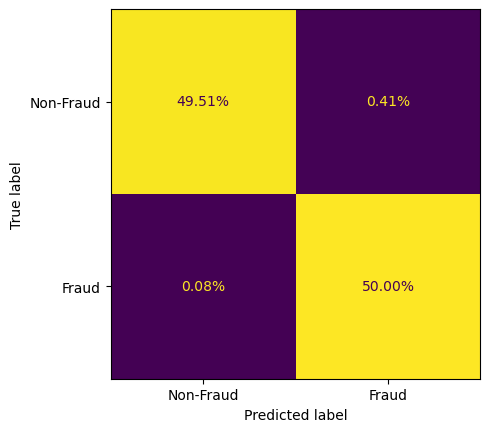

4739/4739 [==============================] - 3s 636us/step


,Train,Validate
Metric,,
Accuracy,0.968598,0.995111
Precision,0.969148,0.991889
Recall,0.967984,0.998402
F1,0.968566,0.995135


In [151]:
nn_pred_pca = ANN_pca.predict(X_test_pca)
nn_pred_binary_pca = (nn_pred_pca > 0.5).astype(int)

cm_nn_pca = cm(y_true=y_test_pca,
               y_pred=nn_pred_binary_pca,
               normalize='all')
nn_metrics_pca = metrics(ANN_pca,
                     X_train_pca,
                     y_train_pca,
                     y_test_pca, 
                     nn_pred_binary_pca)
nn_metrics_pca

In [179]:
# Concat the all metrics data
all_metrics = pd.concat([log_metrics, 
                         SGD_metrics, 
                         GNB_metrics, 
                         CGB_metrics, 
                         nn_metrics], axis=1).T
all_metrics_pca = pd.concat([log_metrics_pca, 
                             SGD_metrics_pca, 
                             GNB_metrics_pca,
                             CGB_metrics_pca,
                             nn_metrics_pca], axis=1).T

# Set index
index_metrics = ["Logistic Regression Train", "Logistic Regression Validate", 
                 "SGDClassifier Train", "SGDClassifier Validate",
                 "GaussianNB Train", "GaussianNB Validate", 
                 "CatBoost Train", "CatBoost Validate", 
                 "Neural Network Train", "Neural Network Validate"]

index_metrics_pca = ["Logistic Regression Train PCA", "Logistic Regression Validate PCA", 
                 "SGDClassifier Train PCA", "SGDClassifier Validate PCA",
                 "GaussianNB Train PCA", "GaussianNB Validate PCA", 
                 "CatBoost Train PCA", "CatBoost Validate PCA", 
                 "Neural Network Train PCA", "Neural Network Validate PCA"]
# Make a copy
all_metrics_df = all_metrics.copy()
all_metrics_df_pca = all_metrics_pca.copy()

In [180]:
# Set the index
all_metrics_df.index = index_metrics
all_metrics_df_pca.index = index_metrics_pca

In [182]:
all_metrics_df = all_metrics_df.applymap(lambda x: f"{x * 100:.3f}%")
all_metrics_df.sort_values(by=["Accuracy", "Precision", "Recall", "F1"], ascending=False)

Metric,Accuracy,Precision,Recall,F1
Neural Network Validate,99.957%,99.914%,100.000%,99.957%
CatBoost Validate,99.865%,99.762%,99.970%,99.866%
CatBoost Train,99.846%,99.729%,99.964%,99.846%
Neural Network Train,99.725%,99.607%,99.843%,99.725%
SGDClassifier Validate,96.548%,98.104%,94.942%,96.497%
SGDClassifier Train,96.535%,98.208%,94.797%,96.472%
Logistic Regression Validate,96.514%,97.692%,95.289%,96.476%
Logistic Regression Train,96.481%,97.787%,95.111%,96.431%
GaussianNB Train,91.889%,97.559%,85.920%,91.371%
GaussianNB Validate,91.815%,97.362%,85.986%,91.321%


In [183]:
all_metrics_df_pca = all_metrics_df_pca.applymap(lambda x: f"{x * 100:.3f}%")
all_metrics_df_pca.sort_values(by=["Accuracy", "Precision", "Recall", "F1"], ascending=False)

Metric,Accuracy,Precision,Recall,F1
Neural Network Validate PCA,99.511%,99.189%,99.840%,99.514%
CatBoost Validate PCA,98.240%,98.891%,97.579%,98.231%
CatBoost Train PCA,98.202%,98.875%,97.511%,98.188%
Neural Network Train PCA,96.860%,96.915%,96.798%,96.857%
SGDClassifier Validate PCA,94.445%,96.120%,92.647%,94.352%
Logistic Regression Validate PCA,94.425%,95.854%,92.886%,94.347%
Logistic Regression Train PCA,94.339%,95.840%,92.697%,94.242%
SGDClassifier Train PCA,94.301%,96.392%,92.043%,94.167%
GaussianNB Train PCA,92.167%,96.620%,87.384%,91.770%
GaussianNB Validate PCA,91.815%,97.362%,85.986%,91.321%
